# Dynamics

In [1]:
import os
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# for prototyping piano-roll visualizations
import pretty_midi as pm
import librosa
import librosa.display
import mir_eval
import mir_eval.display

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('..')

from eval.metrics.benchmarks import *
from eval.metrics.dynamics import *
from eval.metrics.harmony import *
from eval.metrics.articulation import *
from eval.metrics.timing import *

# from config import *
from helpers.analysis import *

# To avoid the following error when running mir_eval.display.piano_roll later:
# AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'
# I rolled back matplotlib to 3.7 as per https://github.com/librosa/librosa/issues/1763#issuecomment-1742120524

print(matplotlib.__version__)
assert matplotlib.__version__ == '3.7.0', 'mir_eval.display.piano_roll needs matplotlib @ 3.7.0'

/mnt/data/tmp/patricia/ipykernel_17886/3575195116.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


3.7.0


We will use the handcrafted example henceforth

In [2]:
ref_midi = '../data/poster_example/mozart_example_gt.mid'
pred_midi = '../data/poster_example/mozart_example_tr.mid'

Load and visualize the example MIDI pair along with the illustration of the selected MIM: **dynamics**

In [3]:
ref_perf = pt.load_performance_midi(ref_midi)
pred_perf = pt.load_performance_midi(pred_midi)

dyn_corr = dynamics_metrics_from_perf(ref_perf, pred_perf)

print(dyn_corr)

0.39562423493237187


break it down

In [4]:
# NOTE: since our Mozart example MIDIs don't make any use of sustain pedal, the following is irrelevant, but just in case:
ref_perf.performedparts[0].sustain_pedal_threshold = 127
pred_perf.performedparts[0].sustain_pedal_threshold = 127

ref_note_array = ref_perf.note_array()
pred_note_array = pred_perf.note_array()

dynamic_range_ref_func, _, _, ref_upper_voice, ref_lower_voice = get_upper_lower_stream_dynamic_range(note_array=ref_note_array, r_b=44.0)
dynamic_range_pred_func, _, _, pred_upper_voice, pred_lower_voice = get_upper_lower_stream_dynamic_range(note_array=pred_note_array, r_b=44.0)

onsets_dyn = ref_note_array["onset_sec"]

ref_dyn_rang = dynamic_range_ref_func(onsets_dyn)
pred_dyn_rang = dynamic_range_pred_func(onsets_dyn)

dyn_corr = np.corrcoef(
    ref_dyn_rang,
    pred_dyn_rang,
)[0, 1]

dyn_corr

0.39562423493237187

Plot

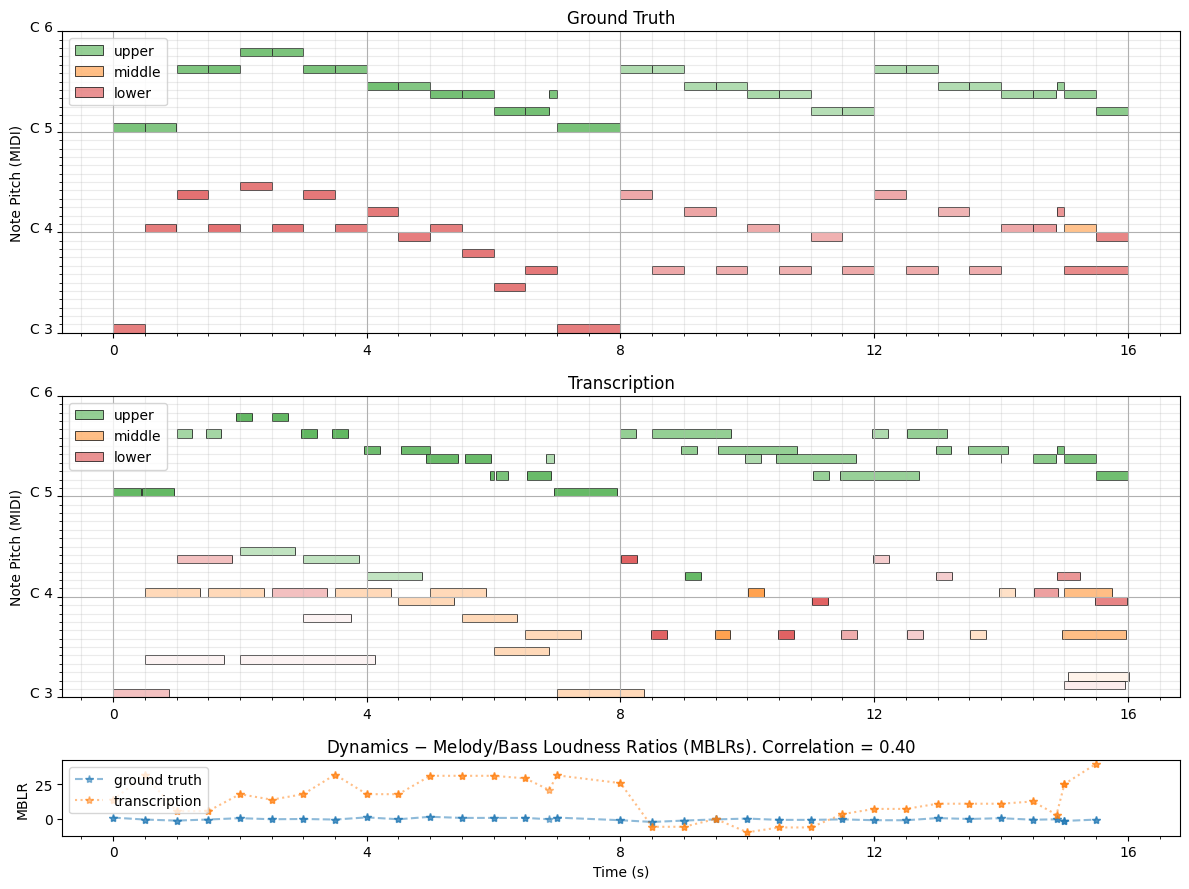

In [ ]:
def get_rgba(color, alpha=0.5):
    import matplotlib.colors as mcolors
    if not hasattr(alpha, '__iter__'):
        return mcolors.to_rgb(color) + (alpha,)
    return [mcolors.to_rgb(color) + (a,) for a in alpha]

def plot_together_pianorolls_IOIs(
        ref_note_array, ref_upper_voice, ref_lower_voice,
        pred_note_array, pred_upper_voice, pred_lower_voice,
        onsets_dyn, ref_dyn_rang, pred_dyn_rang,
        title='',
        ):
    # plot the melody, bass, and middle lines with separate colors, velocity as alpha
    fig, axs = plt.subplots(3, 1, figsize=(16-4, 8+1), sharex=True, gridspec_kw={'height_ratios': [4, 4, 1]})
    # kwargs forwarded to Collection: https://matplotlib.org/3.7.0/api/collections_api.html#matplotlib.collections.Collection

    lw = 0.5
    alpha = 0.5

    # ground truth
    ax = axs[0]

    mir_eval.display.piano_roll([], midi=[],
        label='upper', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    mir_eval.display.piano_roll([], midi=[],
        label='middle', facecolor=get_rgba('tab:orange', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    mir_eval.display.piano_roll([], midi=[],
        label='lower', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in ref_note_array:
        colorname = 'tab:orange'
        if note in ref_upper_voice:
            colorname = 'tab:green'
        elif note in ref_lower_voice:
            colorname = 'tab:red'
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba(colorname, note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))
    
    # transcription
    ax = axs[1]

    mir_eval.display.piano_roll([], midi=[],
        label='upper', facecolor=get_rgba('tab:green', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    mir_eval.display.piano_roll([], midi=[],
        label='middle', facecolor=get_rgba('tab:orange', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    mir_eval.display.piano_roll([], midi=[],
        label='lower', facecolor=get_rgba('tab:red', alpha), edgecolor='black', linewidth=lw, linestyle='-', hatch=None, ax=ax)
    for note in pred_note_array:
        colorname = 'tab:orange'
        if note in pred_upper_voice:
            colorname = 'tab:green'
        elif note in pred_lower_voice:
            colorname = 'tab:red'
        ax.add_patch(plt.Rectangle(
            (note['onset_sec'], note['pitch']), note['duration_sec'], 1.0, facecolor=get_rgba(colorname, note['velocity'] / 127.),
            edgecolor='black', linewidth=lw, linestyle='-', hatch=None))

    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='major')
        ax.grid(True, which='minor', alpha=0.25)
        noterange=(pm.note_name_to_number('C3'), pm.note_name_to_number('C6'))
        ax.set_ybound(lower=noterange[0], upper=noterange[1])
        ax.legend(loc='upper left')

        mir_eval.display.ticker_notes(ax=ax) # replace midi pitch numbers with note names
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12.0)) # major tick each 12 semitones (1 octave)
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=4.0)) # major tick [seconds]
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.5)) # minor tick [seconds]
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.set_ylabel('Note Pitch (MIDI)');
        # ax.set_xlabel('Time (s)');
    
    axs[0].set_title('Ground Truth');
    axs[1].set_title('Transcription');

    # MBLR - Dynamics Correlation
    dyn_corr = np.corrcoef(ref_dyn_rang, pred_dyn_rang)[0, 1]

    ax = axs[2]
    ax.plot(onsets_dyn, ref_dyn_rang, alpha=.5, linestyle='--', marker='*', label='ground truth')
    ax.plot(onsets_dyn, pred_dyn_rang, alpha=.5, linestyle=':', marker='*', label='transcription')
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('MBLR')
    ax.set_title(f'Dynamics $-$ Melody/Bass Loudness Ratios (MBLRs). Correlation = {dyn_corr:.2f}')
    ax.legend(loc='upper left')

    ax.set_xlabel('Time (s)');

    fig.tight_layout()
    
    return fig, axs

fig, axs = plot_together_pianorolls_IOIs(
    ref_note_array, ref_upper_voice, ref_lower_voice,
    pred_note_array, pred_upper_voice, pred_lower_voice,
    onsets_dyn, ref_dyn_rang, pred_dyn_rang,
    title='Running example for illustrating computation of our Musically Informed Metrics')
# supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp
fig.savefig('../poster/poster_fig4_dynamics.pdf', bbox_inches='tight')